# Emotion Classification in texts using LSTM and Word2Vec

### Architecture: 
(X) Text -> Embedding (W2V pretrained on wikipedia articles) -> Deep Network (CNN 1D) -> Fully connected (Dense) -> Output Layer (Softmax) -> Emotion class (Y)

## Workflow: 
1. Import Data
2. Prepare the input data
3. Import pre-trained W2V
4. Create Neural Network Pipeline
5. Train The Model
6. Evaluate results

## 1. Import Data


In [1]:
import pandas as pd
import numpy as np

# text preprocessing
from nltk.tokenize import word_tokenize
import re

# plots and metrics
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# preparing input to our model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

# keras layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense

Defining vector space dimension and fixed input size

In [12]:
# Number of labels: joy, anger, fear, sadness, neutral
num_classes = 8

# Number of dimensions for word embedding
embed_num_dims = 300

# Max input length (max number of words) 
max_seq_len = 500

class_names = ['anger', 'anticipation', 'disgust', 'fear', 'joy','sadness','surprise','trust']

Importing our training and testing datasets

In [4]:
data_train = pd.read_pickle('../traintweet002.pkl') #002 means sampling data
data_test = pd.read_pickle('../df_testtweet.pkl')

X_train = data_train.text
X_test = data_test.text

y_train = data_train.emotion
#y_test = data_test.Emotion

data = data_train.append(data_test, ignore_index=True)

In [5]:
print(data.emotion.value_counts())
data.head(6)

joy             330824
anticipation     47201
sadness          32641
disgust          13140
trust            10710
fear              4387
surprise          1372
anger              808
Name: emotion, dtype: int64


,id,text,emotion
0,0x354002,When your builder really lets you down and the...,joy
1,0x34eb73,@WildKingdumb Just got my @WildKingdumb sticke...,anticipation
2,0x287096,@wearefreeradio Got mine! Can't wait to hear t...,anticipation
3,0x3035d2,@FoxNews @FoxNewsOpinion @ericmetaxas What a <...,disgust
4,0x293a0d,@realDonaIdTrimp @CNN I hope google and outher...,disgust
5,0x36afca,Millions of purple blue-bottomed balderdash ! ...,anger


## 2. Prepare input data
To input the data to our NN Model we'll need some preprocessing:
1. Tokenize our texts and count unique tokens
2. Padding: each input (sentence or text) has to be of the same lenght
3. Labels have to be converted to integeres and categorized

Basic preprocessing and tokenization using nltk to double check that sentences are properly split into words.
We could also add stopword removal but steps like stemming or lemmatization are not needed since we are using word2vec and words with the same stem can have a different meaning

In [6]:
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
import string

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yoyol\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
def clean_text(data):
    
    # remove hashtags and @usernames
    data = re.sub(r"(#[\d\w\.]+)", '', data)
    data = re.sub(r"(@[\d\w\.]+)", '', data)
    #partstop = ["''","'m","'re","'s","'ve",'..','...','....','.....',
    #        '``','’','“','”','lh']

    #stop = set(stopwords.words('english') + list(string.punctuation)+ list(partstop))
    
    
    # tekenization using nltk
    #data = [i for i in word_tokenize(data.lower()) if i not in stop]
    data = word_tokenize(data)
    
    return data

*Making things easier for keras tokenizer 🙃

In [8]:
texts = [' '.join(clean_text(text)) for text in data.text]

texts_train = [' '.join(clean_text(text)) for text in X_train]
texts_test = [' '.join(clean_text(text)) for text in X_test]

In [9]:
print(texts_train[92])

Ready to make notes by and begin ... exciting < LH >


**Tokenization + fitting using keras**

In [10]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)

sequence_train = tokenizer.texts_to_sequences(texts_train)
sequence_test = tokenizer.texts_to_sequences(texts_test)

index_of_words = tokenizer.word_index

# vacab size is number of unique words + reserved 0 index for padding
vocab_size = len(index_of_words) + 1

print('Number of unique words: {}'.format(len(index_of_words)))

Number of unique words: 137039


**Padding** -> each input has the same length

We defined maximun number of words for our texts and input size to our model has to be fixed - padding with zeros to keep the same input lenght (longest input in our dataset is ~250 words)

In [13]:
X_train_pad = pad_sequences(sequence_train, maxlen = max_seq_len )
X_test_pad = pad_sequences(sequence_test, maxlen = max_seq_len )

X_train_pad

array([[    0,     0,     0, ...,     2,    53,     1],
       [    0,     0,     0, ...,     2,  1881,     1],
       [    0,     0,     0, ...,   542,    37,     1],
       ...,
       [    0,     0,     0, ...,  2149,  2927,  5386],
       [    0,     0,     0, ...,   164,     1,     1],
       [    0,     0,     0, ...,    50, 10774,     1]])

**Categorize** labels: 

In [14]:
encoding = {
'anger':       0,
'anticipation': 1,
'disgust':          2,
'fear':          3,
'joy':            4,
'sadness':             5,
'surprise':         6,
'trust':            7
}

# Integer labels
y_train = [encoding[x] for x in data_train.emotion]

data_test_test = pd.read_csv('../testingsubmission5svm.csv')
y_test = [encoding[x] for x in data_test_test.emotion]

In [15]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

## 2. Import pretrained word vectors

* Importing pretrained word2vec from file and creating embedding matrix
* We will later map each word in our corpus to existing word vector

In [16]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    with open(filepath,encoding="utf-8") as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]
    return embedding_matrix

You can download and import any pre-trained word embeddings. I will use 300 dimentional w2v pre-trained on wikipedia articles. Download fast text english vectors: https://fasttext.cc/docs/en/english-vectors.html

In [17]:
import urllib.request
import zipfile
import os

fname = 'embeddings/wiki-news-300d-1M.vec'

if not os.path.isfile(fname):
    print('Downloading word vectors...')
    urllib.request.urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip',
                              'wiki-news-300d-1M.vec.zip')
    print('Unzipping...')
    with zipfile.ZipFile('wiki-news-300d-1M.vec.zip', 'r') as zip_ref:
        zip_ref.extractall('embeddings')
    print('done.')
    
    os.remove('wiki-news-300d-1M.vec.zip')

In [18]:
embedd_matrix = create_embedding_matrix(fname, index_of_words, embed_num_dims)
embedd_matrix.shape

(137040, 300)

Some of the words from our corpus were not included in the pre-trained word vectors. If we inspect those words we'll see that it's mostly spelling errors. It's also good to double check the noise in our data f.e different languages or tokenizer errors.

In [19]:
# Inspect unseen words
new_words = 0

for word in index_of_words:
    entry = embedd_matrix[index_of_words[word]]
    if all(v == 0 for v in entry):
        new_words = new_words + 1

print('Words found in wiki vocab: ' + str(len(index_of_words) - new_words))
print('New words found: ' + str(new_words))

Words found in wiki vocab: 62350
New words found: 74689


## 3. Create CNN Pipeline

### Embedding Layer

We will use pre-trained word vectors. We could also train our own embedding layer if we don't specify the pre-trained weights 

* **vocabulary size:** the maximum number of terms that are used to represent a text: e.g. if we set the size of the “vocabulary” to 1000 only the first thousand terms most frequent in the corpus will be considered (and the other terms will be ignored)
* **the maximum length:** of the texts (which must all be the same length)
* **size of embeddings:** basically, the more dimensions we have the more precise the semantics will be, but beyond a certain threshold we will lose the ability of the embedding to define a coherent and general enough semantic area
* **trainable:** True if you want to fine-tune them while training


In [20]:
# Embedding layer before the actaul BLSTM 
embedd_layer = Embedding(vocab_size,
                         embed_num_dims,
                         input_length = max_seq_len,
                         weights = [embedd_matrix],
                         trainable=False)

### Model Pipeline
- the input is the first N words of each text (with proper padding)
- the first level creates embedding of words, using vocabulary with a certain dimension, and a given size of embeddings
- we will use 1D convolutional neural network to extract features from our data. The result of each convolution will fire when a special pattern is detected. By varying the size of the kernels and concatenating their outputs, you’re allowing yourself to detect patterns of multiples sizes (2, 3, or 5 adjacent words)
- the output level has a number of neurons equal to the classes of the problem and a “softmax” activation function

In [21]:
# Convolution
kernel_size = 3
filters = 256

model = Sequential()
model.add(embedd_layer)
model.add(Conv1D(filters, kernel_size, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(256, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

In [22]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 300)          41112000  
                                                                 
 conv1d (Conv1D)             (None, 498, 256)          230656    
                                                                 
 global_max_pooling1d (Globa  (None, 256)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 256)               65792     
                                                                 
 dense_1 (Dense)             (None, 8)                 2056      
                                                                 
Total params: 41,410,504
Trainable params: 298,504
Non-trainable params: 41,112,000
______________________________________

## 3. Train the Model

In [23]:
X_train_pad.shape

(29111, 500)

In [24]:
batch_size = 256
epochs = 6

hist = model.fit(X_train_pad, y_train, 
                 batch_size=batch_size,
                 epochs=epochs)#,
                 #validation_data=(X_test_pad,y_test))

Epoch 1/6
114/114 [==============================] - 359s 3s/step - loss: 1.6453 - accuracy: 0.3942
Epoch 2/6
114/114 [==============================] - 332s 3s/step - loss: 1.4459 - accuracy: 0.4771
Epoch 3/6
114/114 [==============================] - 410s 4s/step - loss: 1.3109 - accuracy: 0.5325
Epoch 4/6
114/114 [==============================] - 444s 4s/step - loss: 1.1586 - accuracy: 0.5952
Epoch 5/6
114/114 [==============================] - 315s 3s/step - loss: 0.9760 - accuracy: 0.6730
Epoch 6/6
114/114 [==============================] - 280s 2s/step - loss: 0.8058 - accuracy: 0.7358


In [82]:
# Accuracy plot
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Loss plot
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

KeyError: 'acc'

## 4. Evaluation

In [25]:
predictions = model.predict(X_test_pad)
predictions = np.argmax(predictions, axis=1)
predictions = [class_names[pred] for pred in predictions]
predictions

['anticipation',
 'anticipation',
 'sadness',
 'joy',
 'anticipation',
 'disgust',
 'disgust',
 'anticipation',
 'joy',
 'sadness',
 'trust',
 'fear',
 'sadness',
 'joy',
 'fear',
 'sadness',
 'joy',
 'anticipation',
 'joy',
 'anticipation',
 'anticipation',
 'anticipation',
 'anticipation',
 'sadness',
 'joy',
 'anticipation',
 'disgust',
 'sadness',
 'trust',
 'disgust',
 'sadness',
 'sadness',
 'sadness',
 'trust',
 'disgust',
 'sadness',
 'anger',
 'fear',
 'joy',
 'joy',
 'anticipation',
 'anticipation',
 'joy',
 'joy',
 'joy',
 'joy',
 'joy',
 'sadness',
 'sadness',
 'joy',
 'joy',
 'sadness',
 'sadness',
 'joy',
 'sadness',
 'joy',
 'sadness',
 'fear',
 'anger',
 'anticipation',
 'joy',
 'joy',
 'trust',
 'anticipation',
 'trust',
 'joy',
 'anticipation',
 'sadness',
 'sadness',
 'joy',
 'joy',
 'joy',
 'sadness',
 'anticipation',
 'anticipation',
 'sadness',
 'joy',
 'anger',
 'sadness',
 'trust',
 'joy',
 'trust',
 'sadness',
 'joy',
 'joy',
 'joy',
 'joy',
 'joy',
 'disgust',

In [26]:
data_test['emotion']=pd.Series(predictions)
df_result = data_test.drop(['text'],axis=1)
df_result.to_csv('testingsubmission10cnn.csv',index=False)
df_result

,id,emotion
0,0x28b412,anticipation
1,0x2de201,anticipation
2,0x218443,sadness
3,0x2939d5,joy
4,0x26289a,anticipation
...,...,...
411967,0x2913b4,anticipation
411968,0x2a980e,anticipation
411969,0x316b80,sadness
411970,0x29d0cb,trust


In [22]:
print("Accuracy: {:.2f}%".format(accuracy_score(data_test.Emotion, predictions) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(data_test.Emotion, predictions, average='micro') * 100))

Accuracy: 75.66%

F1 Score: 75.66


#### Plotting confusion Matrix:

In [23]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    '''
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    '''
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    
    # Set size
    fig.set_size_inches(12.5, 7.5)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.grid(False)
    
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


F1 Score: 75.66


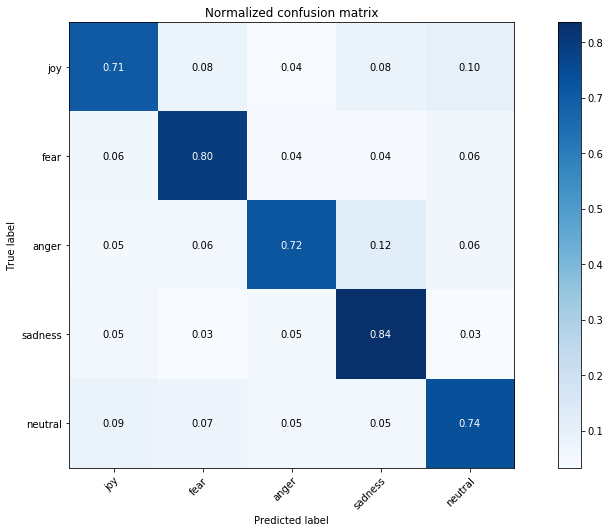

In [24]:
print("\nF1 Score: {:.2f}".format(f1_score(data_test.Emotion, predictions, average='micro') * 100))

# Plot normalized confusion matrix
plot_confusion_matrix(data_test.Emotion, predictions, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

#### Let's try other inputs:

In [25]:
print('Message: {}\nPredicted: {}'.format(X_test[4], predictions[4]))

Message: My boyfriend didn't turn up after promising that he was coming.
Predicted: sadness


In [26]:
import time

message = ['delivery was hour late and my pizza was cold!']

seq = tokenizer.texts_to_sequences(message)
padded = pad_sequences(seq, maxlen=max_seq_len)

start_time = time.time()
pred = model.predict(padded)

print('Message: ' + str(message))
print('predicted: {} ({:.2f} seconds)'.format(class_names[np.argmax(pred)], (time.time() - start_time)))

Message: ['delivery was hour late and my pizza was cold!']
predicted: anger (0.01 seconds)


# Done
Save the model for later use 🙃 

In [27]:
model.save('models/cnn_w2v.h5')

In [28]:
from keras.models import load_model
predictor = load_model('models/cnn_w2v.h5')